# Actividad 5.1. Clasificación de textos. Identificación de humor.

|||
|-|-|
|**Alumno**|Ángel García Alcántara<br><angelgarcan@gmail.com>|
|**Materia**|Recuperación de información<br>en Bases de datos no estructuradas<br>Cuarto Semestre|
|**Fecha**|20 de abril de 2020|

<br>
Implementar las diferentes estrategias de generación de centroides para los clasificadores Nearest Centroid así como las formas de pesado para el clasificador de vecinos cercanos. 

- Una vez implementados aplicar todas las versiones de los mismos al dataset HAHA 2019. Se deben reportar el desempeño. En la siguiente tabla se incluyen las métricas de desempeño a reportar para el clasificador incluido con FastText, así como para el Nerarest Centroid Average y $k$NN con pesado uniforme proporcionado en las palantillas.

------

*Tabla de desempeño para distintos clasificadores utilizando los vectores FastText
pre-entrenados para el idioma español*

------
|Clasificador|Accuracy|Macro F1|Macro Recall|F1 is_humor=1|
|:----------:|:------:|:------:|:----------:|:-----------:|
|FastText| 0.80905 | 0.79327|0.78690|0.73614|
|Nearest Centroid (Average)|0.76475 |0.76006|0.77290|0.72650|
|$k$NN (Pesado Uniforme)|0.79252|0.77397|0.76704|0.70922|
|Nearest Centroid (Rocchio)|
|Nearest Centroid (Suma)|
|Nearest Centroid (Suma normalizada)| 
|$k$NN (distancia mínima media)|  
|$k$NN (distancia pesada)| 

------
<br />

En su reporte deberá completar la tabla con los resultados para cada una de las variaciones de los alagoritmos propuestos. 

- Generar los una representación con pesado tfidf para el dataset HAHA 2019, posteriormente aplicar los clasificadores implementados a la representación generada. Incluir los resultados en forma de tabla. Justificar los resultados obtenidos en función de como son con los obtenidos sobre los vectores pre-entrenado

In [1]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
// Evitar autoscroll.
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from skeleton import *
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)
import os

In [4]:
def testClassifier(clf,train,y_train,test,y_test):
    print("=== ",clf.__class__.__name__,end='')
    print(":",vars(clf))
    clf=clf.fit(train,y_train)
    #Predecimos las etiqueta del conjunto de prueba
    yp=clf.predict(test)
    # Medidas de bondad
    scores={}

    scores['Accuracy']=accuracy_score(y_test,yp)
    scores['Macro F1']=f1_score(y_test,yp,average='macro')
    scores['Macro Recall']=recall_score(y_test,yp,average='macro')
    scores['F1 is_humor=1']=f1_score(y_test,yp)
    
    print("Accuracy","Macro F1","Macro Recall","F1 is_humor=1",sep='\t')
    print("{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(
        scores['Accuracy'],scores['Macro F1'],scores['Macro Recall'],scores['F1 is_humor=1']))
                            
#     print("Recall: ", scores['recall'])
#     print("F1: ", scores['f1'])
#     print("Accuracy: ", scores['accuracy'])
#     print("F1 Humor: ", scores['f1_humor'])
    #Vemos la frontera de decisión
    plotDecisionBoundary(clf,train, y_train)
    return scores

## Un problema de texto  (Identificación de humor HAHA -2019)

Para este ejemplo utilizaremos los datos proporcionados para la tarea 1 del HAHA - Humor Analysis based on Human Annotation, la cual consiste determinar si tweets en español son humorísticos o no (un problema de clasificación binaria). Esta tarea forma parte del Iberian Languages Evaluation Forum (IberLEF 2019).

### Corpus 

El conjunto de datos fue etiquetado como se indica [5]. Todos los tweets están etiquetados como humorístico **is_humor=1**  o no humorístico **is_humor=0**. Los datos relevantes para el problema se clasificación ser muestran en el siguiente ejemplo:

|Desscripción|Clave|Valor|
|:------:|:------:|:-----:|
|Tweet |text|Después de la tormenta sale... Tu mamá gritando porque no metiste la ropa.|
|Etiqueta de clase|is_humor|1|
|Representación vectorial|vec| Vectores de dimensión 300 (FastText preentrenados para español) |
|Identificador|id|942079817905770496|



In [5]:
# Cargamos lod datos.
train_data=pd.read_json('data/haha_train_ft_pre.json',lines=True)

In [6]:
#Vemos los primeros 5
train_data.head()[['id','text','is_humor','vec']]

,id,text,is_humor,vec
0,965767017268678658,Amo a @CamilaTuDiosaxD,0,"[-0.06692000000000001, 0.13184, -0.0030723, -0..."
1,965811724392726528,@NamiNapoleon hola como estan me pueden seguir,0,"[-0.06776, -0.24253000000000002, -0.0065559999..."
2,964984559547777024,Típico : Estar viajando en taxi y pensar tácti...,1,"[-0.044634, -0.049435, -0.053049, -0.026851, 0..."
3,941669646364762113,Me gusta todo de ti.. te amo espejo.,1,"[-0.022054999999999998, -0.064284, -0.052083, ..."
4,1009142890415652866,""" Egipto siempre acaba afuera ""\r\n\r\nCleopatra",1,"[0.066164, -0.082201, -0.022706, -0.047533, 0...."


In [7]:
#Dimensión de los vectores
len(train_data.vec[3])

300

In [8]:
# Los datos de prueba
test_data=pd.read_json('data/haha_test_ft_pre.json',lines=True)

In [9]:
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
train,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.is_humor)
test,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.is_humor)

===  NearestCentroid: {'distance': <function coseno at 0x7fb3a186f9e0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fb3c03d8750>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.758506	0.754136	0.767883	0.721359


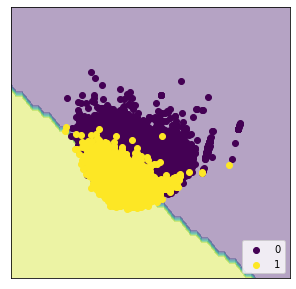

===  NearestCentroid: {'distance': <function euclidiana at 0x7fb3a3d47e60>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fb3c03d8d10>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.764755	0.760063	0.772908	0.726510


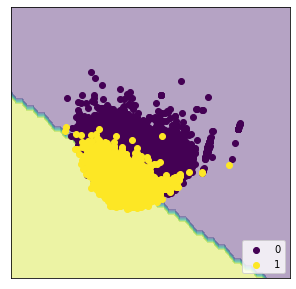

===  NearestCentroid: {'distance': <function coseno at 0x7fb3a186f9e0>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fb3a03780d0>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.758506	0.754136	0.767883	0.721359


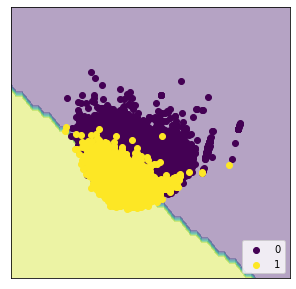

===  NearestCentroid: {'distance': <function euclidiana at 0x7fb3a3d47e60>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fb3a0378510>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.386335	0.278674	0.500000	0.557347


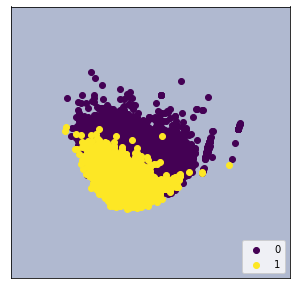

===  NearestCentroid: {'distance': <function coseno at 0x7fb3a186f9e0>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fb3a0378a90>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.756562	0.752360	0.766565	0.720102


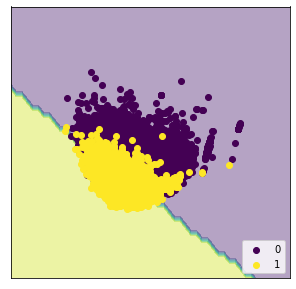

===  NearestCentroid: {'distance': <function euclidiana at 0x7fb3a3d47e60>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fb381383890>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.487849	0.446826	0.579715	0.597468


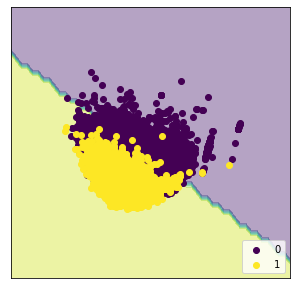

===  NearestCentroid: {'distance': <function coseno at 0x7fb3a186f9e0>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fb380da22d0>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.758506	0.754136	0.767883	0.721359


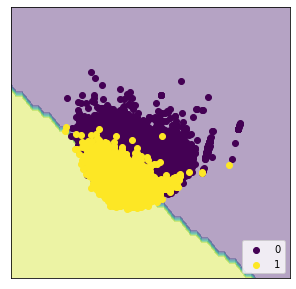

===  NearestCentroid: {'distance': <function euclidiana at 0x7fb3a3d47e60>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fb380183490>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.758506	0.754136	0.767883	0.721359


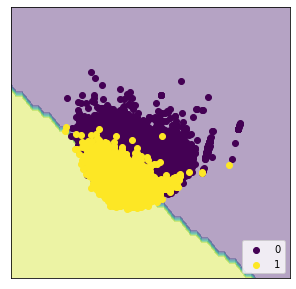

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fb3619d5210>>, 'distance': 'coseno', 'k': 5}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.792529	0.773978	0.767041	0.709225


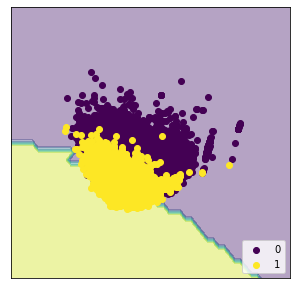

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fb360dc3a50>>, 'distance': 'euclidiana', 'k': 5}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.788918	0.777797	0.778281	0.728086


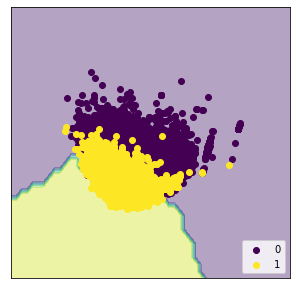

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fb360a0be10>>, 'distance': 'coseno', 'k': 5}
Implementación mean_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.695181	0.680171	0.681133	0.610885
Implementación mean_dist


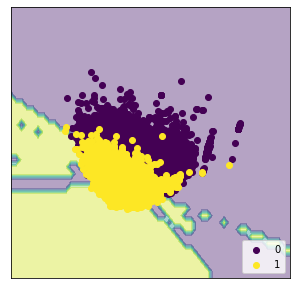

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fb35fbe5550>>, 'distance': 'euclidiana', 'k': 5}
Implementación mean_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.736425	0.726118	0.730052	0.672984
Implementación mean_dist


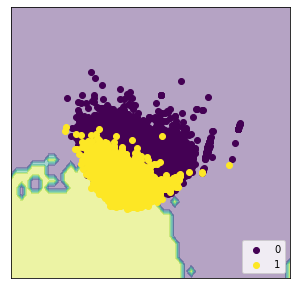

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fb35fa57850>>, 'distance': 'coseno', 'k': 5}
Implementación weighed_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.792529	0.773978	0.767041	0.709225
Implementación weighed_dist


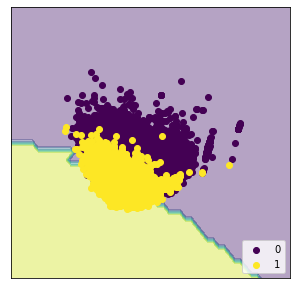

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fb35f050f90>>, 'distance': 'euclidiana', 'k': 5}
Implementación weighed_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.787946	0.776788	0.777289	0.726882
Implementación weighed_dist


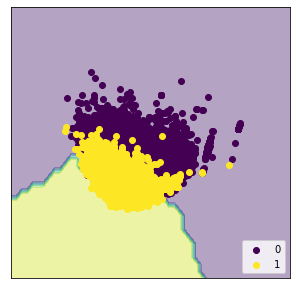

In [10]:
P={"FastText":{"Accuracy":0.809050,"Macro F1":0.793270,"Macro Recall":0.786900,"F1 is_humor=1":0.736140}} #Performance

# 
P["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train,y_train,test,y_test)
P["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train,y_train,test,y_test)

P["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train,y_train,test,y_test)
P["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train,y_train,test,y_test)

P["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio',beta=16,gamma=4),train,y_train,test,y_test)
P["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio',beta=16,gamma=4),train,y_train,test,y_test)

P["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train,y_train,test,y_test)
P["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train,y_train,test,y_test)


P["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train,y_train,test,y_test)
P["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train,y_train,test,y_test)

P["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train,y_train,test,y_test)
P["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train,y_train,test,y_test)

P["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)
P["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)

In [10]:
from toolbox import *

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
!rm -f *.pickle
!wc -l data/haha_*.json
# !cat data/haha_train_ft_pre_min10.json > data/haha_all_ft_pre_min10.json
# !cat data/haha_test_ft_pre_min10.json >> data/haha_all_ft_pre_min10.json
# !wc -l data/haha_all_ft_pre_min10.json
!cat data/haha_train_ft_pre.json > data/haha_all_ft_pre.json
!cat data/haha_test_ft_pre.json >> data/haha_all_ft_pre.json
!wc -l data/haha_all_ft_pre.json

!rm -f *.pickle
inv_idx = InvertedIdx("data/haha_all_ft_pre.json")
inv_idx.process(showProgressEach=10000, stemm=False)
inv_idx.compute_mtx()
tfidf=pd.DataFrame(inv_idx.idx_mtx.todense(), index=inv_idx.corpus).T
tfidf

    24000 data/haha_all_ft_pre.json
      240 data/haha_all_ft_pre_min10.json
     7201 data/haha_test_ft_pre.json
       72 data/haha_test_ft_pre_min10.json
    16799 data/haha_train_ft_pre.json
      168 data/haha_train_ft_pre_min10.json
    48480 total
24000 data/haha_all_ft_pre.json
** Processing data/haha_all_ft_pre.json ...
2020-05-09 04:45:06.292085 :: 0.000884 - Processing item #0 
2020-05-09 04:45:07.846334 :: 1.555133 - Processing item #10000 
2020-05-09 04:45:09.392990 :: 3.101789 - Processing item #20000 
** Processed 24000 lines. Saved to /home/jovyan/B5_Clasificacion/tokenized_docs.pickle.
** Computing TF-IDF...
** Computed TF-IDF Matrix !!!
** Done poda0 TF-IDF Matrix !!!
poda0_mtx.pickle written.


<29910x24000 sparse matrix of type '<class 'numpy.float64'>'
	with 173667 stored elements in List of Lists format>

,aa,aaborto,aacacaa,aagg,aaghh,aah,aahh,aajajfkajd,aamhigha,aamm,...,zumbidos,zumo,zup,zuper,zuperman,zurro,zuv,zygyrs,zz,zzi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
train_n=len(train_data)
test_n=len(test_data)
train_n,test_n

(16799, 7201)

In [ ]:
te=np.asarray(tfidf.tail(test_n),order='F')

In [ ]:
test3=np.array(tfidf.tail(int(test_n/2)))

In [14]:
test2=np.array(tfidf.tail(int(test_n/2)))

In [19]:
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
train2,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.is_humor)
test2,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.is_humor)

True

In [ ]:
test2=np.array([np.array(row) for _, row in tfidf.tail(test_n).iterrows()])

In [13]:
train2=np.array(tfidf.head(train_n))
test2=np.array(tfidf.tail(test_n))
train2.shape,test2.shape

((16799, 29910), (7201, 29910))

In [ ]:
train2=np.ascontiguousarray(tfidf.head(train_n).to_numpy())
test2=np.ascontiguousarray(tfidf.tail(test_n).to_numpy())
train2.shape,test2.shape

(16799, 7201)

In [ ]:
P2={} #Performance

# 
P2["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train2,y_train,test2,y_test)
P2["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train2,y_train,test2,y_test)

P2["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train2,y_train,test2,y_test)
P2["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train2,y_train,test2,y_test)

P2["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio',beta=16,gamma=4),train2,y_train,test2,y_test)
P2["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio',beta=16,gamma=4),train2,y_train,test2,y_test)

P2["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train2,y_train,test2,y_test)
P2["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train2,y_train,test2,y_test)


P2["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train2,y_train,test2,y_test)
P2["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train2,y_train,test2,y_test)

P2["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train2,y_train,test2,y_test)
P2["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train2,y_train,test2,y_test)

P2["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train2,y_train,test2,y_test)
P2["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train2,y_train,test2,y_test)

In [ ]:
df=pd.DataFrame(P).T.sort_values("F1 is_humor=1",ascending =False)
df

In [ ]:
df2=pd.DataFrame(P2).T.sort_values("F1 is_humor=1",ascending =False)
df2

In [ ]:
df.describe()

In [ ]:
df2.describe()